In [2]:
%pip install tqdm

     ---------------------------------------- 78.4/78.4 kB 2.1 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2 -> 22.2.2
[notice] To update, run: C:\Users\domie\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import agb.string.agbstring
import agb.image, agb.palette, agb.lz77
import struct
from pymap.project import Project
import json
from PIL import Image, ImageDraw
import numpy as np
from copy import deepcopy
import os
from collections import defaultdict
import pickle, pathlib
from tqdm import tqdm
import os.path as osp

In [4]:
%pwd

'\\\\wsl$\\Ubuntu\\home\\dominik\\Violet\\Violet'

In [9]:
%ls base\\bprd.gba

 Volume in Laufwerk Z: hat keine Bezeichnung.
 Volumeseriennummer: 0000-0000

 Verzeichnis von Z:\home\dominik\Violet\Violet\base

25.12.1996  00:32        16.777.216 bprd.gba
               1 Datei(en),     16.777.216 Bytes
               0 Verzeichnis(se), 250.709.532.672 Bytes frei


In [13]:
with open(os.path.join('.', 'bld', 'violet.gba'), 'rb') as f:
    rom = f.read()
with open(os.path.join('.', 'base', 'bpre.gba'), 'rb') as f:
    bpre = f.read()
agbstring = agb.string.agbstring.Agbstring('charmap.txt')
project = Project('proj.pmp')
with open('bprd.sym') as f:
    lines = f.read().splitlines()
symbols = {}
with open(os.path.join('.', 'bld', 'symbols')) as f:
    for line in f.read().splitlines():
        if len(line.strip()) == 0:
            continue
        try:
            off, token = line.split(' ')
        except:
            continue
        off = int(off, 16)
        if not token.startswith('.'):
            symbols[token] = off
ROM_START = 0x8000000

In [14]:
def constantize(table, value):
    table = project.constants[table]
    for constant in table:
        if table[constant] == value:
            return constant
    return hex(value)
def find_pointers(rom, offset, attempts=100, add_rom_offset=True):
    if add_rom_offset:
        offset += 0x8000000
    pattern = bytes([offset & 255, (offset >> 8) & 255, (offset >> 16) & 255, (offset >> 24) & 255])
    matches = []
    offset = -1
    for _ in range(100):
        try: 
            offset = rom.index(pattern, offset + 1)
            matches.append(offset)
        except: break
    return matches

In [50]:
find_pointers(rom, 0x3decbc)

[641476]

In [49]:
for i in range(project.constants['items']['ITEM_ENIGMABEERE'] + 1 - project.constants['items']['ITEM_AMRENABEERE']):
    off = 0x03decbc + 0x1c * (i + 1)
    off_en = 0x03df7cc + 0x1c * (i + 1)
    name = agbstring.hex_to_str(rom, off)[0].capitalize()
    name_en = agbstring.hex_to_str(bpre, off_en)[0].capitalize()
    firmness = project.model['u8'].from_data(rom, off + 7, project, [], [])
    size = project.model['u16'].from_data(rom, off + 8, project, [], [])
    max_yield = project.model['u8'].from_data(rom, off + 10, project, [], [])
    min_yield = project.model['u8'].from_data(rom, off + 11, project, [], [])
    #print(hex(project.model['pointer'].from_data(rom, off + 12, project, [], [])))
    #descr0 = agbstring.hex_to_str(rom, project.model['pointer'].from_data(rom, off + 12, project, [], []))
    #print(descr0)
    # descr1 = agbstring.hex_to_str(rom, project.model['pointer'].from_data(rom, off + 16, project, [], []))
    stage_duration = project.model['u8'].from_data(rom, off + 0x14, project, [], [])
    spicy = project.model['u8'].from_data(rom, off + 0x15, project, [], [])
    dry = project.model['u8'].from_data(rom, off + 0x16, project, [], [])
    sweet = project.model['u8'].from_data(rom, off + 0x17, project, [], [])
    bitter = project.model['u8'].from_data(rom, off + 0x18, project, [], [])
    sour = project.model['u8'].from_data(rom, off + 0x19, project, [], [])
    smoothness = project.model['u8'].from_data(rom, off + 0x1a, project, [], [])
    
    item_idx = constantize('items', i + project.constants['items']['ITEM_AMRENABEERE'])
    print(f'[ITEM_IDX_TO_BERRY_IDX({item_idx})]  = ' + '{')
    print(f'\t.name = LANGDEP(PSTRING("{name}"), PSTRING("{name_en}")),')
    print(f'\t.firmness = {firmness}, .size = {size},')
    print(f'\t.max_yield = {max_yield}, .min_yield = {min_yield}, .stage_duration = {stage_duration},')
    print(f'\t.spicy = {spicy}, .dry = {dry}, .sweet = {sweet},')
    print(f'\t.bitter = {bitter}, .sour = {sour}, .smoothness = {smoothness},')
    print('},')
    

[ITEM_IDX_TO_BERRY_IDX(ITEM_AMRENABEERE)]  = {
	.name = LANGDEP(PSTRING("Amrena"), PSTRING("Cheri")),
	.firmness = 2, .size = 20,
	.max_yield = 3, .min_yield = 2, .stage_duration = 3,
	.spicy = 10, .dry = 0, .sweet = 0,
	.bitter = 0, .sour = 0, .smoothness = 25,
},
[ITEM_IDX_TO_BERRY_IDX(ITEM_MARONBEERE)]  = {
	.name = LANGDEP(PSTRING("Maron"), PSTRING("Chesto")),
	.firmness = 5, .size = 80,
	.max_yield = 3, .min_yield = 2, .stage_duration = 3,
	.spicy = 0, .dry = 10, .sweet = 0,
	.bitter = 0, .sour = 0, .smoothness = 25,
},
[ITEM_IDX_TO_BERRY_IDX(ITEM_PIRSIFBEERE)]  = {
	.name = LANGDEP(PSTRING("Pirsif"), PSTRING("Pecha")),
	.firmness = 1, .size = 40,
	.max_yield = 3, .min_yield = 2, .stage_duration = 3,
	.spicy = 0, .dry = 0, .sweet = 10,
	.bitter = 0, .sour = 0, .smoothness = 25,
},
[ITEM_IDX_TO_BERRY_IDX(ITEM_FRAGIABEERE)]  = {
	.name = LANGDEP(PSTRING("Fragia"), PSTRING("Rawst")),
	.firmness = 3, .size = 32,
	.max_yield = 3, .min_yield = 2, .stage_duration = 3,
	.spicy = 0, .dry =

[ITEM_IDX_TO_BERRY_IDX(ITEM_PALLMBEERE)]  = {
	.name = LANGDEP(PSTRING("Pallm"), PSTRING("Pamtre")),
	.firmness = 1, .size = 244,
	.max_yield = 2, .min_yield = 1, .stage_duration = 18,
	.spicy = 0, .dry = 40, .sweet = 10,
	.bitter = 0, .sour = 0, .smoothness = 70,
},
[ITEM_IDX_TO_BERRY_IDX(ITEM_WASMELBEERE)]  = {
	.name = LANGDEP(PSTRING("Wasmel"), PSTRING("Watmel")),
	.firmness = 2, .size = 250,
	.max_yield = 2, .min_yield = 1, .stage_duration = 18,
	.spicy = 0, .dry = 0, .sweet = 40,
	.bitter = 10, .sour = 0, .smoothness = 70,
},
[ITEM_IDX_TO_BERRY_IDX(ITEM_DURINBEERE)]  = {
	.name = LANGDEP(PSTRING("Durin"), PSTRING("Durin")),
	.firmness = 3, .size = 280,
	.max_yield = 2, .min_yield = 1, .stage_duration = 18,
	.spicy = 0, .dry = 0, .sweet = 0,
	.bitter = 40, .sour = 10, .smoothness = 70,
},
[ITEM_IDX_TO_BERRY_IDX(ITEM_ANTIKER_SAMEN)]  = {
	.name = LANGDEP(PSTRING("Myrtil"), PSTRING("Belue")),
	.firmness = 1, .size = 300,
	.max_yield = 2, .min_yield = 1, .stage_duration = 18,
	.spicy

In [14]:
anims = []
for i in range(12):
    off = 0x03a352c + 4 * i
    anim = project.model['pointer'].from_data(rom, off, project, [], [])
    print('static gfx_frame hiro_rod_animations_' + str(i) + '[] = {')
    while True:
        vf, hf = False, False
        data = project.model['u16'].from_data(rom, anim, project, [], [])
        duration = project.model['u16'].from_data(rom, anim + 2, project, [], [])
        if duration & 0x80:
            vf = True
            duration -= 0x80
        if duration & 0x40:
            hf = True
            duration -= 0x40
    
        if vf:
            duration = f'{duration} | GFX_ANIM_VFLIP'
        if hf:
            duration = f'{duration} | GFX_ANIM_HFLIP'
            
        data = {
            0xFFFF : 'GFX_ANIM_END',
            0xFFFE : 'GFX_ANIM_JUMP',
            0xFFFD : 'GFX_ANIM_JUMP_LOOP_START',
        }.get(data, data)
        
        print('\t{.data = ' + str(data) + ', .duration = ' + str(duration) + '},')
        if data in ('GFX_ANIM_END', 'GFX_ANIM_JUMP'):
            break
        anim += 4
    print('};\n')
    
    #print(f'ow_hiro_gfx_animation_table_rod_{i} = {hex(anim)};')
    
for i in range(12):
    print(f'[{i}] = hiro_rod_animations_{i},')

static gfx_frame hiro_rod_animations_0[] = {
	{.data = 8, .duration = 4},
	{.data = 9, .duration = 4},
	{.data = 10, .duration = 4},
	{.data = 11, .duration = 4},
	{.data = GFX_ANIM_END, .duration = 0},
};

static gfx_frame hiro_rod_animations_1[] = {
	{.data = 4, .duration = 4},
	{.data = 5, .duration = 4},
	{.data = 6, .duration = 4},
	{.data = 7, .duration = 4},
	{.data = GFX_ANIM_END, .duration = 0},
};

static gfx_frame hiro_rod_animations_2[] = {
	{.data = 0, .duration = 4},
	{.data = 1, .duration = 4},
	{.data = 2, .duration = 4},
	{.data = 3, .duration = 4},
	{.data = GFX_ANIM_END, .duration = 0},
};

static gfx_frame hiro_rod_animations_3[] = {
	{.data = 0, .duration = 4 | GFX_ANIM_HFLIP},
	{.data = 1, .duration = 4 | GFX_ANIM_HFLIP},
	{.data = 2, .duration = 4 | GFX_ANIM_HFLIP},
	{.data = 3, .duration = 4 | GFX_ANIM_HFLIP},
	{.data = GFX_ANIM_END, .duration = 0},
};

static gfx_frame hiro_rod_animations_4[] = {
	{.data = 11, .duration = 4},
	{.data = 10, .duration = 6},
	{.da

In [16]:
for off in find_pointers(rom, 0x0203988c + 32, add_rom_offset=False):
    print('.org', hex(off + 0x8000000))
    print('\t.word bag_pockets + 32')

.org 0x813d31c
	.word bag_pockets + 32
.org 0x813d9a0
	.word bag_pockets + 32


In [10]:
for off in find_pointers(rom, 0x3c2b2c):
    print('.org', hex(off + 0x8000000))
    print('\t.word gfx_weather_defaultPal')

.org 0x8079c34
	.word gfx_weather_defaultPal
.org 0x80afca0
	.word gfx_weather_defaultPal
.org 0x80aff40
	.word gfx_weather_defaultPal


In [14]:

image_offset = 0
pal_offset = 0x3c2b2c
image = agb.image.Image(rom[:8*8 // 2], 8, 8)
palette = agb.palette.from_data(rom[pal_offset : pal_offset + 32])
image.to_pil_image(palette.to_pil_palette())

image.save('default.png', palette.to_pil_palette())

In [5]:
ground_effect_names = ['GROUND_EFFECT_FLAG_TALL_GRASS_ON_SPAWN',
'GROUND_EFFECT_FLAG_TALL_GRASS_ON_MOVE',
'GROUND_EFFECT_FLAG_LONG_GRASS_ON_SPAWN',
'GROUND_EFFECT_FLAG_LONG_GRASS_ON_MOVE',
'GROUND_EFFECT_FLAG_ICE_REFLECTION',
'GROUND_EFFECT_FLAG_REFLECTION',
'GROUND_EFFECT_FLAG_SHALLOW_FLOWING_WATER (1 << 6)',
'GROUND_EFFECT_FLAG_SAND',
'GROUND_EFFECT_FLAG_DEEP_SAND',
'GROUND_EFFECT_FLAG_RIPPLES',
'GROUND_EFFECT_FLAG_PUDDLE',
'GROUND_EFFECT_FLAG_SAND_PILE',
'GROUND_EFFECT_FLAG_LAND_IN_TALL_GRASS',
'GROUND_EFFECT_FLAG_LAND_IN_LONG_GRASS',
'GROUND_EFFECT_FLAG_LAND_IN_SHALLOW_WATER (1 << 14)',
'GROUND_EFFECT_FLAG_LAND_IN_DEEP_WATER',
'GROUND_EFFECT_FLAG_LAND_ON_NORMAL_GROUND (1 << 16)',
'GROUND_EFFECT_FLAG_SHORT_GRASS',
'GROUND_EFFECT_FLAG_HOT_SPRINGS',
'GROUND_EFFECT_FLAG_SEAWEED',
'GROUND_EFFECT_FLAG_SNOW']

for idx, name in enumerate(ground_effect_names):
    offset = 0x3a6f80 + 4 * idx
    func = project.model['u32'].from_data(rom, offset, project, [], []) & (~1)
    #print(name.lower(), '=', hex(func), '| 1;')
    #print('void', name.lower(), '(npc *n, oam *o);')
    print(f'[{name}] = {name.lower().replace("flags_", "")},')

[GROUND_EFFECT_FLAG_TALL_GRASS_ON_SPAWN] = ground_effect_flag_tall_grass_on_spawn,
[GROUND_EFFECT_FLAG_TALL_GRASS_ON_MOVE] = ground_effect_flag_tall_grass_on_move,
[GROUND_EFFECT_FLAG_LONG_GRASS_ON_SPAWN] = ground_effect_flag_long_grass_on_spawn,
[GROUND_EFFECT_FLAG_LONG_GRASS_ON_MOVE] = ground_effect_flag_long_grass_on_move,
[GROUND_EFFECT_FLAG_ICE_REFLECTION] = ground_effect_flag_ice_reflection,
[GROUND_EFFECT_FLAG_REFLECTION] = ground_effect_flag_reflection,
[GROUND_EFFECT_FLAG_SHALLOW_FLOWING_WATER (1 << 6)] = ground_effect_flag_shallow_flowing_water (1 << 6),
[GROUND_EFFECT_FLAG_SAND] = ground_effect_flag_sand,
[GROUND_EFFECT_FLAG_DEEP_SAND] = ground_effect_flag_deep_sand,
[GROUND_EFFECT_FLAG_RIPPLES] = ground_effect_flag_ripples,
[GROUND_EFFECT_FLAG_PUDDLE] = ground_effect_flag_puddle,
[GROUND_EFFECT_FLAG_SAND_PILE] = ground_effect_flag_sand_pile,
[GROUND_EFFECT_FLAG_LAND_IN_TALL_GRASS] = ground_effect_flag_land_in_tall_grass,
[GROUND_EFFECT_FLAG_LAND_IN_LONG_GRASS] = ground_effe

In [8]:
for bank, maps in project.headers.items():
    for map_idx in maps:
        header, header_label, namespace = project.load_header(bank, map_idx)
        for person in header['events']['persons']:
            person['argument'] = person.pop('field_3')
            person['script_std_and_in_connection'] = {
                'script_std' : person.pop('script_std'),
                'in_connection' : str(0),
            }
        project.save_header(header, bank, map_idx)

In [6]:
with open('bld/pokeapi/updated.pkl', 'rb') as f:
    updated = pickle.load(f)

In [8]:
updated[1]

{'name': {'LANG_GER': 'Bisasam', 'LANG_EN': 'Bulbasaur'},
 'egg_group_0': 'Monster',
 'egg_group_1': 'Pflanze',
 'gender_ratio': 32,
 'capture_rate': 200,
 'base_happiness': 70,
 'egg_cycles': 20,
 'color_and_flip': {'flip': 0, 'color': 'Grün'},
 'shape': 'Quadruped',
 'growth_rate': 'medium-slow',
 'evolutions': {'POKEMON_BISAKNOSP': {'trigger': 'Level_Up',
   'argument': 16,
   'baby_trigger_item': None}},
 'dex_entry': {'LANG_GER': 'Nach der Geburt nimmt es für eine Weile Nährstoffe über den Samen auf seinem Rücken auf.',
  'LANG_EN': 'For some time after its birth, it grows by gaining nourishment from the seed on its back.'},
 'genus': {'LANG_GER': 'Samen', 'LANG_EN': 'Seed'},
 'height': 7,
 'weight': 69,
 'exp_yield': 64,
 'hidden_ability': 'Photogenese',
 'ability_0': 'Notduenger',
 'ability_1': None,
 'basestats': {'hp': 45,
  'attack': 49,
  'defense': 49,
  'special-attack': 65,
  'special-defense': 65,
  'speed': 45},
 'ev_yield': {'Padding': 0,
  'hp': 0,
  'attack': 0,
  'd

In [42]:
sym_cry_backward = symbols['pokemon_cries_backward']
sym_cry_forward = symbols['pokemon_cries_forward']
_off_to_sym = {off : sym for sym, off in symbols.items()}
species_to_cry = {}

sym_to_cry = defaultdict(list)

for species in project.constants['species']:
    if species == 'POKEMON_CNT':
        break
    
    def get_cry(off):
        off -= 0x8000000
        header = [project.model['u8'].from_data(rom, off + i, project, [], []) for i in range(4)]
        cry = project.model['u32'].from_data(rom, off + 4, project, [], [])
        vol_curve = [project.model['u8'].from_data(rom, off + i + 8, project, [], []) for i in range(4)]
        return header, cry, vol_curve
    
    header_forward, cry_forward, vol_curve_forward = get_cry(sym_cry_forward + 12 * project.constants['species'][species])
    header_backward, cry_backward, vol_curve_backward = get_cry(sym_cry_backward + 12 * project.constants['species'][species])
    
    if (cry_forward != cry_backward):
        print('cries not equal', species, hex(cry_forward), hex(cry_backward))
        raise
    cry = _off_to_sym.get(cry_forward, cry_forward)
    sym_to_cry[cry].append(species)
    species_to_cry[species] = cry
        
for sym, species_set in sym_to_cry.items():
    species_set = [species for species in species_set if not '_MEGA_' in species] # Remove megas
    if len(species_set) == 1:
        species = species_set[0]
    elif len(species_set) > 1:
        for mon in ('POKEMON_ICOGNITO', 'POKEMON_ROTOM', 'POKEMON_DURENGARD', 'POKEMON_KECLEON',
                   'POKEMON_GROUDON', 'POKEMON_ONIX'):
            if mon in species_set:
                species = mon
                break
        else:
            raise RuntimeError(f'{species_set}')
        # Remove mega pokemon
    else:
        raise RuntimeError(f'{species_set}')
    sym_to_cry[sym] = species
    

In [43]:
int_sym_to_sym = {}
for sym, species in sym_to_cry.items():
    if isinstance(sym, int):
        # print(f'cry_{species[8:].lower()} = {hex(sym)};')
        int_sym_to_sym[sym] = f'cry_{species[8:].lower()}'
        #print(f'extern u8 cry_{species[8:].lower()}[];')

In [45]:
for species, cry in species_to_cry.items():
    if isinstance(cry, int):
        species_to_cry[species] = int_sym_to_sym[cry]

In [57]:
for species in project.constants['species']:
    if species == 'POKEMON_CNT':
        break
    
    def get_cry(off):
        off -= 0x8000000
        header = [project.model['u8'].from_data(rom, off + i, project, [], []) for i in range(4)]
        cry = project.model['u32'].from_data(rom, off + 4, project, [], [])
        vol_curve = [project.model['u8'].from_data(rom, off + i + 8, project, [], []) for i in range(4)]
        return header, cry, vol_curve
    
    header_forward, cry_forward, vol_curve_forward = get_cry(sym_cry_forward + 12 * project.constants['species'][species])
    header_backward, cry_backward, vol_curve_backward = get_cry(sym_cry_backward + 12 * project.constants['species'][species])
    print(f'\t[{species}] = ', '{', f'.header =', '{', ", ".join(map(hex, header_backward)), '},', f'.cry = {species_to_cry[species]}, .vol_curve =', '{', ", ".join(map(hex, vol_curve_backward)),'}},')
    

	[POKEMON_POKEMON_0] =  { .header = { 0x30, 0x3c, 0x0, 0x0 }, .cry = cry_icognito, .vol_curve = { 0xff, 0x0, 0xff, 0x0 }},
	[POKEMON_BISASAM] =  { .header = { 0x30, 0x3c, 0x0, 0x0 }, .cry = cry_bisasam, .vol_curve = { 0xff, 0x0, 0xff, 0x0 }},
	[POKEMON_BISAKNOSP] =  { .header = { 0x30, 0x3c, 0x0, 0x0 }, .cry = cry_bisaknosp, .vol_curve = { 0xff, 0x0, 0xff, 0x0 }},
	[POKEMON_BISAFLOR] =  { .header = { 0x30, 0x3c, 0x0, 0x0 }, .cry = cry_bisaflor, .vol_curve = { 0xff, 0x0, 0xff, 0x0 }},
	[POKEMON_GLUMANDA] =  { .header = { 0x30, 0x3c, 0x0, 0x0 }, .cry = cry_glumanda, .vol_curve = { 0xff, 0x0, 0xff, 0x0 }},
	[POKEMON_GLUTEXO] =  { .header = { 0x30, 0x3c, 0x0, 0x0 }, .cry = cry_glutexo, .vol_curve = { 0xff, 0x0, 0xff, 0x0 }},
	[POKEMON_GLURAK] =  { .header = { 0x30, 0x3c, 0x0, 0x0 }, .cry = cry_glurak, .vol_curve = { 0xff, 0x0, 0xff, 0x0 }},
	[POKEMON_SCHIGGY] =  { .header = { 0x30, 0x3c, 0x0, 0x0 }, .cry = cry_schiggy, .vol_curve = { 0xff, 0x0, 0xff, 0x0 }},
	[POKEMON_SCHILLOK] =  { .heade

	[POKEMON_PUPITAR] =  { .header = { 0x30, 0x3c, 0x0, 0x0 }, .cry = cry_pupitar, .vol_curve = { 0xff, 0x0, 0xff, 0x0 }},
	[POKEMON_DESPOTAR] =  { .header = { 0x30, 0x3c, 0x0, 0x0 }, .cry = cry_despotar, .vol_curve = { 0xff, 0x0, 0xff, 0x0 }},
	[POKEMON_LUGIA] =  { .header = { 0x30, 0x3c, 0x0, 0x0 }, .cry = cry_lugia, .vol_curve = { 0xff, 0x0, 0xff, 0x0 }},
	[POKEMON_HO_OH] =  { .header = { 0x30, 0x3c, 0x0, 0x0 }, .cry = cry_ho_oh, .vol_curve = { 0xff, 0x0, 0xff, 0x0 }},
	[POKEMON_CELEBI] =  { .header = { 0x30, 0x3c, 0x0, 0x0 }, .cry = cry_celebi, .vol_curve = { 0xff, 0x0, 0xff, 0x0 }},
	[POKEMON_ROTOM_HEAT] =  { .header = { 0x30, 0x3c, 0x0, 0x0 }, .cry = cry_479, .vol_curve = { 0xff, 0x0, 0xff, 0x0 }},
	[POKEMON_ROTOM_WASH] =  { .header = { 0x30, 0x3c, 0x0, 0x0 }, .cry = cry_479, .vol_curve = { 0xff, 0x0, 0xff, 0x0 }},
	[POKEMON_ROTOM_FORST] =  { .header = { 0x30, 0x3c, 0x0, 0x0 }, .cry = cry_479, .vol_curve = { 0xff, 0x0, 0xff, 0x0 }},
	[POKEMON_ROTOM_WIND] =  { .header = { 0x30, 0x3c,

In [71]:
frontsprite_table = symbols['pokemon_frontsprites'] - ROM_START
backsprite_table = symbols['pokemon_backsprites'] - ROM_START
palettes = symbols['pokemon_pals'] - ROM_START
shiny_pals = symbols['pokemon_shiny_pals'] - ROM_START

def pokemon_gfx(idx):
    gfx_front = project.model['pointer'].from_data(rom, frontsprite_table + 8 * idx, project, [], [])
    gfx_back = project.model['pointer'].from_data(rom, backsprite_table + 8 * idx, project, [], [])
    pal = project.model['pointer'].from_data(rom, palettes + 8 * idx, project, [], [])
    pal_shiny = project.model['pointer'].from_data(rom, shiny_pals + 8 * idx, project, [], [])
    
    gfx_front = agb.image.Image(agb.lz77.decompress(rom, offset=gfx_front), 64, 64)
    gfx_back = agb.image.Image(agb.lz77.decompress(rom, offset=gfx_back), 64, 64)
    pal = agb.palette.from_data(agb.lz77.decompress(rom, offset=pal))
    pal_shiny = agb.palette.from_data(agb.lz77.decompress(rom, offset=pal_shiny))
    return gfx_front, gfx_back, pal, pal_shiny
    
for _iter, species in tqdm(enumerate(list(project.constants['species']))):
    if species == 'POKEMON_CNT':
        break
    idx = project.constants['species'][species]
    gfx_front, gfx_back, pal, pal_shiny = pokemon_gfx(idx)
    name = species[8:].lower()
    
    gfx_front.save(
        f'asset/pokemon/gfx/gfx_pokemon_{name}_frontsprite.png', 
        pal.to_pil_palette()
    )
    with open(f'asset/pokemon/gfx/gfx_pokemon_{name}_frontsprite.grit', 'w+') as f:
        f.write('-gu32 -gzl -gB 4 -gt -p -pu16 -pzl -m!')
    gfx_back.save(
        f'asset/pokemon/gfx/gfx_pokemon_{name}_backsprite.png', 
        pal_shiny.to_pil_palette()
    )
    with open(f'asset/pokemon/gfx/gfx_pokemon_{name}_backsprite.grit', 'w+') as f:
        f.write('-gu32 -gzl -gB 4 -gt -p -pu16 -pzl -m!')


443it [00:05, 75.92it/s]


In [75]:
for _iter, species in tqdm(enumerate(list(project.constants['species']))):
    if species == 'POKEMON_CNT':
        break
    idx = project.constants['species'][species]
    name = species[8:].lower()
    # print(f'extern const u8 gfx_pokemon_{name}_frontspriteTiles[];')
    print(f'\t[{species}] = ' + '{.pal = ' + f'gfx_pokemon_{name}_frontspritePal, .tag = {species},' + '},' )

443it [00:00, 11486.13it/s]

	[POKEMON_POKEMON_0] = {.pal = gfx_pokemon_pokemon_0_frontspritePal, .tag = POKEMON_POKEMON_0,},
	[POKEMON_BISASAM] = {.pal = gfx_pokemon_bisasam_frontspritePal, .tag = POKEMON_BISASAM,},
	[POKEMON_BISAKNOSP] = {.pal = gfx_pokemon_bisaknosp_frontspritePal, .tag = POKEMON_BISAKNOSP,},
	[POKEMON_BISAFLOR] = {.pal = gfx_pokemon_bisaflor_frontspritePal, .tag = POKEMON_BISAFLOR,},
	[POKEMON_GLUMANDA] = {.pal = gfx_pokemon_glumanda_frontspritePal, .tag = POKEMON_GLUMANDA,},
	[POKEMON_GLUTEXO] = {.pal = gfx_pokemon_glutexo_frontspritePal, .tag = POKEMON_GLUTEXO,},
	[POKEMON_GLURAK] = {.pal = gfx_pokemon_glurak_frontspritePal, .tag = POKEMON_GLURAK,},
	[POKEMON_SCHIGGY] = {.pal = gfx_pokemon_schiggy_frontspritePal, .tag = POKEMON_SCHIGGY,},
	[POKEMON_SCHILLOK] = {.pal = gfx_pokemon_schillok_frontspritePal, .tag = POKEMON_SCHILLOK,},
	[POKEMON_TURTOK] = {.pal = gfx_pokemon_turtok_frontspritePal, .tag = POKEMON_TURTOK,},
	[POKEMON_DARTIRI] = {.pal = gfx_pokemon_dartiri_frontspritePal, .tag = POK

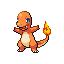

In [68]:
def center_image(image):
    row_mask = np.ones(image.data.shape[0], dtype=bool)
    col_mask = np.ones(image.data.shape[1], dtype=bool)
    
    # Find border empty rows and cols
    for axis, mask in ((1, row_mask), (0, col_mask)):
        for idx, is_empty in enumerate((image.data == 0).all(axis=axis)):
            if is_empty:
                mask[idx] = False
            else:
                break
        for idx, is_empty in enumerate((image.data == 0).all(axis=axis)[::-1]):
            if is_empty:
                mask[-idx - 1] = False
            else:
                break
    
    content = image.data[row_mask]
    content = content[:, col_mask]
    w, h = content.shape
    
    data_new = np.zeros_like(image.data)
    x0 = (data_new.shape[0] - w + 1) // 2
    y0 = (data_new.shape[1] - h + 1) // 2
    data_new[x0 : x0 + w, y0 : y0 + h] = content
    image.data = data_new
    
    return w, h
    
img, pal = agb.image.from_file('asset/pokemon/gfx/gfx_pokemon_glumanda_frontsprite.png') 
center_image(img)
img.to_pil_image(pal.to_pil_palette())

In [24]:
icon_usage = 0x01921B24
player_y_off = 0x0992616C - 0x8000000
alt_off = 0x09926858 - 0x8000000
for species in project.constants['species']:
    idx = project.constants['species'][species]
    icon_idx = project.model['u8'].from_data(rom, icon_usage + idx, project, [], [])
    size = project.model['u8'].from_data(rom, player_y_off + 4 * idx, project, [], [])
    yoff = project.model['u8'].from_data(rom, player_y_off + 4 * idx + 1, project, [], [])
    alt = project.model['u8'].from_data(rom, alt_off + idx, project, [], [])
    width, height = size & 0xF, (size >> 4) & 0xF
    print(f'[{species}] = ' + '{' + f'.width = POKEMON_COORDINATE_SIZE({width * 8}), .height = POKEMON_COORDINATE_SIZE({height * 8}), .y_offset = {yoff}' + '},')

[POKEMON_POKEMON_0] = {.width = POKEMON_COORDINATE_SIZE(64), .height = POKEMON_COORDINATE_SIZE(64), .y_offset = 0},
[POKEMON_BISASAM] = {.width = POKEMON_COORDINATE_SIZE(40), .height = POKEMON_COORDINATE_SIZE(40), .y_offset = 16},
[POKEMON_BISAKNOSP] = {.width = POKEMON_COORDINATE_SIZE(48), .height = POKEMON_COORDINATE_SIZE(48), .y_offset = 10},
[POKEMON_BISAFLOR] = {.width = POKEMON_COORDINATE_SIZE(56), .height = POKEMON_COORDINATE_SIZE(64), .y_offset = 4},
[POKEMON_GLUMANDA] = {.width = POKEMON_COORDINATE_SIZE(40), .height = POKEMON_COORDINATE_SIZE(40), .y_offset = 13},
[POKEMON_GLUTEXO] = {.width = POKEMON_COORDINATE_SIZE(48), .height = POKEMON_COORDINATE_SIZE(56), .y_offset = 9},
[POKEMON_GLURAK] = {.width = POKEMON_COORDINATE_SIZE(64), .height = POKEMON_COORDINATE_SIZE(64), .y_offset = 1},
[POKEMON_SCHIGGY] = {.width = POKEMON_COORDINATE_SIZE(40), .height = POKEMON_COORDINATE_SIZE(48), .y_offset = 12},
[POKEMON_SCHILLOK] = {.width = POKEMON_COORDINATE_SIZE(48), .height = POKEMON_C

In [8]:
label = 'maptileset_cloud_various'
tss = project.load_tileset(False, label)
tss_backup = deepcopy(tss)
for idx in range(0x280 - 0x280, 0x32c - 0x280):
    metablock = tss['blocks'][idx]
    behv = tss['behaviours'][idx]
    for k in behv:
        behv[k] = '0'
    behv['battle_bg'] = 'BATTLE_BG_SKY_ISLAND'
    for block in metablock:
        block['tile_idx'] = 0
        block['palette_idx'] = 0
        block['horizontal_flip'] = 0
        block['vertical_flip'] = 0

In [9]:
project.save_tileset(False, tss, label)

In [29]:
tsp = project.load_tileset(True, 'maptileset0')
tss = project.load_tileset(False, 'maptileset_tafelberg')

In [23]:
tss = project.load_tileset(False, 'maptileset19')

In [24]:
tss_backup = deepcopy(tss)

In [4]:
for idx in range([0x308 - 0x280 :]):
    for block in metablock:
        block['tile_idx'] = 0
        block['palette_idx'] = 0
        block['horizontal_flip'] = 0
        block['vertical_flip'] = 0

SyntaxError: invalid syntax (<ipython-input-4-8bc3071eb8f6>, line 1)

In [26]:
for beh in tss['behaviours'][0x308 - 0x280:]:
    for k in beh:
        beh[k] = 0
    beh['battle_bg'] = 'BATTLE_BG_GYM'

In [27]:

project.save_tileset(False, tss, 'maptileset19')

In [30]:
mountain = deepcopy(tsp['blocks'][0xe0:0x118])
mountain2 = deepcopy(tsp['blocks'][0xe0:0x118])
mountain_behaviours = tsp['behaviours'][0xe0 : 0x118]
for block in mountain:
    for tile in block:
        if tile['palette_idx'] == 0:
            tile['palette_idx'] = 7
for block in mountain2:
    for tile in block:
        if tile['palette_idx'] == 0:
            tile['palette_idx'] = 8
    
tss['blocks'][0x2f8 - 0x280 : 0x2f8 - 0x280 + 56] = mountain
tss['behaviours'][0x2f8 - 0x280 : 0x2f8 - 0x280 + 56] = mountain_behaviours
tss['blocks'][0x2f8 - 0x280 + 56 : 0x2f8 - 0x280 + 2 * 56] = mountain2
tss['behaviours'][0x2f8 - 0x280 + 56 : 0x2f8 - 0x280 + 2 * 56] = mountain_behaviours

In [20]:
tss['blocks'][0x2f8 : 0x2fe]

[]

In [5]:
import pickle
with open('bld/index/pokemon.pkl', 'rb') as f:
    pindex = pickle.load(f)

In [13]:
pindex['pokedex_entries'][2]

{'genus': 'Samen',
 'height': 10,
 'weight': 130,
 'entry_string_0': 'Sobald die Knospe auf seinem Rücken\\nein süßes Aroma abgibt, steht die\\nBlüte kurz bevor.',
 'entry_string_1': None,
 'field_14': 0,
 'pokemon_scale': 0,
 'pokemon_displace': 0,
 'trainer_scale': 0,
 'trainer_displace': 0,
 'field_1E': 0}

In [21]:
bs = project.model['basestats'].from_data(rom, symbols['basestats'] , project, [], [])

In [29]:
pokedex_order = project.model['pokedex_order'].from_data(rom, symbols['pokedex_order'], project, [], [])

In [33]:
pokedex_entries = project.model['pokedex_entries'].from_data(rom, symbols['pokedex_entries'], project, [], [])

In [40]:
levelup_moves = project.model['levelup_moves'].from_data(rom, symbols['pokemon_moves'], project, [], [])

In [45]:
accessible_moves = project.model['accessible_moves'].from_data(rom, symbols['pokemon_accessible_moves'], project, [], [])

In [73]:
move_tutor_compatibility = project.model['tutor_compatibilities'].from_data(rom, symbols['pokemon_move_tutor_compatibility'], project, [], [])
move_tutor_compatibility[3]

49664

In [70]:
tm_hm_to_attack = project.model['tm_hm_to_attack'].from_data(rom, symbols['tm_hm_to_attack'], project, [], [])
tm_hm_comptability = project.model['tm_compatibilities'].from_data(rom, symbols['pokemon_tm_compatibility'], project, [], [])
def tm_hm_compatibility_to_list(compatiblity):
    l = []
    for i in range(50 + 8):
        if compatiblity[i // 8] & (1 << (i & 7)):
            if i < 50:
                name = ('TM', i + 1)
            else:
                name = ('VM', i - 50 + 1)
            l.append((name, tm_hm_to_attack[i]))
    return l

tm_hm_compatibility_to_list(tm_hm_comptability[6])
    

[(('TM', 1), 'ATTACK_POWER_PUNCH'),
 (('TM', 2), 'ATTACK_DRACHENKLAUE'),
 (('TM', 5), 'ATTACK_BRUELLER'),
 (('TM', 6), 'ATTACK_TOXIN'),
 (('TM', 10), 'ATTACK_KRAFTRESERVE'),
 (('TM', 11), 'ATTACK_SONNENTAG'),
 (('TM', 15), 'ATTACK_HYPERSTRAHL'),
 (('TM', 17), 'ATTACK_SCHUTZSCHILD'),
 (('TM', 21), 'ATTACK_FRUSTRATION'),
 (('TM', 22), 'ATTACK_SOLARSTRAHL'),
 (('TM', 23), 'ATTACK_EISENSCHWEIF'),
 (('TM', 26), 'ATTACK_ERDBEBEN'),
 (('TM', 27), 'ATTACK_RUECKKEHR'),
 (('TM', 28), 'ATTACK_SCHAUFLER'),
 (('TM', 31), 'ATTACK_DURCHBRUCH'),
 (('TM', 32), 'ATTACK_DOPPELTEAM'),
 (('TM', 33), 'ATTACK_REFLEKTOR'),
 (('TM', 35), 'ATTACK_FLAMMENWURF'),
 (('TM', 37), 'ATTACK_SANDSTURM'),
 (('TM', 38), 'ATTACK_FEUERSTURM'),
 (('TM', 39), 'ATTACK_FELSGRAB'),
 (('TM', 40), 'ATTACK_AERO_ASS'),
 (('TM', 42), 'ATTACK_FASSADE'),
 (('TM', 43), 'ATTACK_GEHEIMPOWER'),
 (('TM', 44), 'ATTACK_ERHOLUNG'),
 (('TM', 45), 'ATTACK_ANZIEHUNG'),
 (('TM', 47), 'ATTACK_STAHLFLUEGEL'),
 (('TM', 50), 'ATTACK_HITZEKOLLER'),
 ((

In [44]:
egg_moves = project.model['egg_moves'].from_data(rom, symbols['pokemon_egg_moves'], project, [], [])
egg_moves

[None,
 ['ATTACK_SCHAEDELWUMME',
  'ATTACK_AUSDAUER',
  'ATTACK_NATUR_KRAFT',
  'ATTACK_BLAETTERTANZ',
  'ATTACK_ZAUBERBLATT',
  'ATTACK_CHARME',
  'ATTACK_BLAETTERSTURM',
  'ATTACK_SCHLAMMBAD',
  'ATTACK_FLUCH',
  'ATTACK_AMNESIE',
  'ATTACK_GRASFLOETE',
  'ATTACK_VERWURZLER',
  'ATTACK_GIGASAUGER'],
 None,
 None,
 ['ATTACK_PRUEGLER',
  'ATTACK_METALLKLAUE',
  'ATTACK_WINDSCHNITT',
  'ATTACK_KNIRSCHER',
  'ATTACK_WUTANFALL',
  'ATTACK_BISS',
  'ATTACK_FLAMMENBLITZ',
  'ATTACK_POWER_PUNCH',
  'ATTACK_BAUCHTROMMEL',
  'ATTACK_DRACHENTANZ',
  'ATTACK_DRACHENPULS',
  'ATTACK_ANTIK_KRAFT',
  'ATTACK_KONTER'],
 None,
 None,
 ['ATTACK_GAEHNER',
  'ATTACK_MOGELHIEB',
  'ATTACK_FONTRAENEN',
  'ATTACK_DRESCHFLEGEL',
  'ATTACK_LEHMSUHLER',
  'ATTACK_GESICHTE',
  'ATTACK_AURASPHAERE',
  'ATTACK_WASSERDUESE',
  'ATTACK_LEHMBRUEHE',
  'ATTACK_SPIEGELCAPE',
  'ATTACK_DUNKELNEBEL',
  'ATTACK_WEISSNEBEL',
  'ATTACK_DRACHENPULS',
  'ATTACK_HEILUNG'],
 None,
 None,
 ['ATTACK_UEBERNAHME'],
 None,
 None,


In [34]:
pokedex_entries[2]

{'genus': 'Samen',
 'height': 10,
 'weight': 130,
 'entry_string_0': 'Sobald die Knospe auf seinem Rücken\\nein süßes Aroma abgibt, steht die\\nBlüte kurz bevor.',
 'entry_string_1': None,
 'field_14': 0,
 'pokemon_scale': 0,
 'pokemon_displace': 0,
 'trainer_scale': 0,
 'trainer_displace': 0,
 'field_1E': 0}

In [27]:
dex_numbers = [0] + [project.model['u16'].from_data(rom, symbols['pokedex_order'] + 2 * species, project, [], []) for species in range(1, len(bs))]

In [25]:
symbols['pokedex_order']

25401460

In [8]:
hex(symbols['basestats'])

'0x1841cc4'

In [4]:
project.constants['species']['POKEMON_AMFIRA']

368

In [5]:
import pickle
with open('pokeapi/pokeapi_stats.pkl', 'rb') as f:
    apistats = pickle.load(f)

apistats[project.constants['species']['POKEMON_MOLUNK']]

{'name': {'LANG_GER': 'Molunk', 'LANG_EN': 'Salandit'},
 'egg_group_0': 'Monster',
 'egg_group_1': 'Drache',
 'gender_ratio': 32,
 'capture_rate': 120,
 'base_happiness': 70,
 'egg_cycles': 20,
 'color_and_flip': {'flip': 0, 'color': 'Schwarz'},
 'shape': 'Quadruped',
 'growth_rate': 'medium',
 'evolutions': {'POKEMON_AMFIRA': {'trigger': 'Level_Up',
   'argument': 33,
   'baby_trigger_item': None}},
 'dex_entry': {'LANG_GER': 'Lebt in Vulkanen und trockenen Felsgebieten. Mit seinem süßlich duftenden Giftgas lockt es Käfer-Pokémon an, um sie anzugreifen.',
  'LANG_EN': 'Volcanoes or dry, craggy places are its home. It emanates a sweet-smelling poisonous gas that attracts bug Pokémon, then attacks them.'},
 'genus': {'LANG_GER': 'Giftechse', 'LANG_EN': 'Toxic Lizard'},
 'height': 6,
 'weight': 48,
 'exp_yield': 64,
 'hidden_ability': 'Dösigkeit',
 'ability_0': 'Korrosion',
 'ability_1': None,
 'basestats': {'hp': 48,
  'attack': 44,
  'defense': 40,
  'special-attack': 71,
  'special-de

In [15]:
project.constants['species']['POKEMON_MOLUNK']

367

In [10]:
import pickle
with open('bld/pokeapi/updated.pkl', 'rb') as f:
    updated = pickle.load(f)

updated[project.constants['species']['POKEMON_ROTOM']]

{'name': {'LANG_GER': 'Minun', 'LANG_EN': 'Minun'},
 'egg_group_0': 'Fee',
 'egg_group_1': 'Fee',
 'gender_ratio': 127,
 'capture_rate': 200,
 'base_happiness': 70,
 'egg_cycles': 20,
 'color_and_flip': {'flip': 0, 'color': 'Gelb'},
 'shape': 'Upright',
 'growth_rate': 'medium',
 'evolutions': {},
 'dex_entry': {'LANG_EN': 'Exposure to electricity from Minun and Plusle promotes blood circulation and relaxes muscles.',
  'LANG_GER': 'Mit elektrischen Schlägen regen Plusle und Minun den Blutkreislauf an und lösen so Verspannungen.'},
 'genus': {'LANG_EN': 'Cheering', 'LANG_GER': 'Jubel'},
 'height': 4,
 'weight': 42,
 'exp_yield': 142,
 'hidden_ability': None,
 'ability_0': 'Schwebe',
 'ability_1': None,
 'basestats': {'speed': 95,
  'special-defense': 85,
  'special-attack': 75,
  'defense': 50,
  'attack': 40,
  'hp': 60},
 'ev_yield': {'Padding': 0,
  'speed': 1,
  'special-defense': 0,
  'special-attack': 0,
  'defense': 0,
  'attack': 0,
  'hp': 0},
 'levelup_moves': [('Heuler', 1),

In [4]:
for offset in find_pointers(rom, 0x3c2a0c):
    print(hex(offset + 0x8000000))

In [5]:
funcs = 0x03c2a0c
for i, weather in enumerate(project.constants['map_weathers']):
    name = weather[4:].lower()
    init_vars = project.model['u32'].from_data(rom, funcs + 16 * i, project, [], [])
    main = project.model['u32'].from_data(rom, funcs + 16 * i + 4, project, [], [])
    init_all = project.model['u32'].from_data(rom, funcs + 16 * i + 8, project, [], [])
    finish = project.model['u32'].from_data(rom, funcs + 16 * i + 12, project, [], [])
    print(f'{name}_initialize_variables = {hex(init_vars - 1)} | 1;')
    print(f'{name}_main = {hex(main - 1)} | 1;')
    print(f'{name}_initialize_all = {hex(init_all - 1)} | 1;')
    print(f'{name}_closure = {hex(finish - 1)} | 1;')
    """
    print(f'void {name}_initialize_variables();')
    print(f'void {name}_main();')
    print(f'void {name}_initialize_all();')
    print(f'bool {name}_closure();')
    """
    # print(f'[{weather}] = ' + '{' + f'.initialize_variables = {name}_initialize_variables, .main = {name}_main, .initialize_all = {name}_initialize_all, .closure = {name}_closure' + ' },')
    
    "Rain_InitVars,          Rain_Main,          Rain_InitAll,          Rain_Finish"
    
    

weather_inside_initialize_variables = 0x8079e24 | 1;
weather_inside_main = 0x8079e44 | 1;
weather_inside_initialize_all = 0x8079e24 | 1;
weather_inside_closure = 0x8079e48 | 1;
weather_sunny_with_cloud_reflection_initialize_variables = 0x807b240 | 1;
weather_sunny_with_cloud_reflection_main = 0x807b2bc | 1;
weather_sunny_with_cloud_reflection_initialize_all = 0x807b28c | 1;
weather_sunny_with_cloud_reflection_closure = 0x807b31c | 1;
weather_outside_initialize_variables = 0x807b364 | 1;
weather_outside_main = 0x807b394 | 1;
weather_outside_initialize_all = 0x807b388 | 1;
weather_outside_closure = 0x807b398 | 1;
weather_rain_initialize_variables = 0x807b72c | 1;
weather_rain_main = 0x807b7c8 | 1;
weather_rain_initialize_all = 0x807b798 | 1;
weather_rain_closure = 0x807b828 | 1;
weather_snow_initialize_variables = 0x807bd90 | 1;
weather_snow_main = 0x807be4c | 1;
weather_snow_initialize_all = 0x807bde0 | 1;
weather_snow_closure = 0x807be88 | 1;
weather_thunder_initialize_variables = 0x80

In [6]:
import pickle
with open('bld/pokeapi/stats.pms') as f:
    d = json.load(f)['data']
safari = {constantize('species', i) : d[i]['safari_rate'] for i in range(len(d))}
safari

{'POKEMON_POKEMON_0': 0,
 'POKEMON_BISASAM': 0,
 'POKEMON_BISAKNOSP': 0,
 'POKEMON_BISAFLOR': 0,
 'POKEMON_GLUMANDA': 0,
 'POKEMON_GLUTEXO': 0,
 'POKEMON_GLURAK': 0,
 'POKEMON_SCHIGGY': 0,
 'POKEMON_SCHILLOK': 0,
 'POKEMON_TURTOK': 0,
 'POKEMON_DARTIRI': 0,
 'POKEMON_DARTIGNIS': 0,
 'POKEMON_FIARO': 0,
 'POKEMON_HORNLIU': 0,
 'POKEMON_KOKUNA': 0,
 'POKEMON_BIBOR': 0,
 'POKEMON_STARALILI': 0,
 'POKEMON_STARAVIA': 0,
 'POKEMON_STARAPTOR': 0,
 'POKEMON_BRONZEL': 0,
 'POKEMON_BRONZONG': 0,
 'POKEMON_MAEHIKEL': 0,
 'POKEMON_CHEVRUMM': 0,
 'POKEMON_PARAGONI': 0,
 'POKEMON_TROMBORK': 0,
 'POKEMON_PIKACHU': 0,
 'POKEMON_RAICHU': 0,
 'POKEMON_SANDAN': 0,
 'POKEMON_SANDAMER': 0,
 'POKEMON_NIDORANW': 50,
 'POKEMON_NIDORINA': 75,
 'POKEMON_NIDOQUEEN': 0,
 'POKEMON_NIDORANM': 50,
 'POKEMON_NIDORINO': 75,
 'POKEMON_NIDOKING': 0,
 'POKEMON_FLOETTE': 0,
 'POKEMON_FLORGES': 0,
 'POKEMON_VULPIX': 0,
 'POKEMON_VULNONA': 0,
 'POKEMON_PUMMELUFF': 0,
 'POKEMON_KNUDDELUFF': 0,
 'POKEMON_ZUBAT': 0,
 'POKEMON_

In [12]:
ow_effects = 0x1dd944
for i, eff in enumerate(project.constants['overworld/overworld_effects']):
    off = project.model['u32'].from_data(rom, ow_effects + 4 * i, project, [], [])
    label = f'overworld_effect_script_{eff.lower().replace("overworld_effect_", "")}'
    #print(f'{label} = {hex(off)};')
    #print(f'extern const u8 {label}[];')
    print(f'[{eff}] = {label},')

[OVERWORLD_EFFECT_EXCLAMATION_MARK_ICON] = overworld_effect_script_exclamation_mark_icon,
[OVERWORLD_EFFECT_USE_CUT_ON_GRASS] = overworld_effect_script_use_cut_on_grass,
[OVERWORLD_EFFECT_USE_CUT_ON_TREE] = overworld_effect_script_use_cut_on_tree,
[OVERWORLD_EFFECT_SHADOW] = overworld_effect_script_shadow,
[OVERWORLD_EFFECT_TALL_GRASS] = overworld_effect_script_tall_grass,
[OVERWORLD_EFFECT_RIPPLE] = overworld_effect_script_ripple,
[OVERWORLD_EFFECT_FIELD_MOVE_SHOW_MON] = overworld_effect_script_field_move_show_mon,
[OVERWORLD_EFFECT_ASH] = overworld_effect_script_ash,
[OVERWORLD_EFFECT_SURF_BLOB] = overworld_effect_script_surf_blob,
[OVERWORLD_EFFECT_USE_SURF] = overworld_effect_script_use_surf,
[OVERWORLD_EFFECT_DUST] = overworld_effect_script_dust,
[OVERWORLD_EFFECT_USE_SECRET_POWER_CAVE] = overworld_effect_script_use_secret_power_cave,
[OVERWORLD_EFFECT_JUMP_TALL_GRASS] = overworld_effect_script_jump_tall_grass,
[OVERWORLD_EFFECT_SAND_FOOTPRINTS] = overworld_effect_script_sand_foot

In [10]:
header, label, ns = project.load_header(15, 0)
for idx, person in enumerate(header['events']['persons']):
    person['target_index'] = str(idx + 1)
project.save_header(header, 15, 0)

In [4]:



for bank, maps in project.headers.items():
    for map_idx in maps:
        
        print(bank, map_idx)
        header, header_label, namespace = project.load_header(bank, map_idx)
        for person in header['events']['persons']:
            person['value']['berry_tree_idx'] = 0
        #project.save_header(header, bank, map_idx)
        
    


0 7
0 12
0 5
0 6
0 13
1 0
1 81
1 82
1 126
1 59
1 125
1 30
1 31
1 1
1 2
3 0
3 1
3 2
3 67
3 4
3 5
3 6
3 72
3 73
3 74
3 75
3 76
3 66
3 3
3 21
3 22
3 23
3 24
3 70
3 41
3 19
3 57
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
4 0
4 1
4 2
4 4
4 3
4 5
5 0
5 2
5 4
5 11
5 12
5 13
5 1
6 0
6 1
6 2
6 3
6 5
6 9
6 13
6 14
6 15
6 4
6 6
6 7
7 1
7 2
7 3
7 5
7 8
7 10
7 0
8 0
8 4
8 6
8 7
8 8
8 9
8 10
8 11
8 1
8 2
9 1
9 3
9 9
9 10
9 11
9 12
9 13
9 14
9 15
9 16
9 17
9 18
9 19
9 0
9 2
9 4
10 16
10 12
10 20
10 22
10 0
10 1
10 2
15 0
15 1
15 4
15 5
15 2
16 3
16 4
16 0
17 2
17 3
18 2
18 3
18 0
2 33
11 0
11 1
11 2
11 3
11 4
11 5
11 6
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
13 0
13 1
13 2
13 3
13 4
13 5
14 0
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10
20 0
21 0
22 0
22 1
23 0
24 0
25 0
26 0
26 1
27 0
27 1
27 2
27 3
27 4
27 5
27 6
27 7
28 0
29 0
29 1
29 2
29 3
29 4
29 5
29 6
31 0
31 1
31 2
31 3
31 4
31 5
31 6
31 7
31 8
31 9
31 10
31 11
31 12
31 13
31 14
31 15
31 16
31 17
32 0
32 1
32 2
32 3


In [14]:
saved_headers

{('0', '7')}

In [5]:
def offset_label_to_offset(label):
    label = str(label)
    if label == '0': return None
    if not label.startswith('ow_script'): return None
    try:
        return int(script.replace('ow_script_', ''), 0)
    except:
        return None
    
    

In [6]:
UPDATE_EVENTS = True

# Create a lut for new better symbol names
symbol_map = dict()
unmapped_symbols = list()

for bank, maps in project.headers.items():
    for map_idx in maps:
        header, header_label, namespace = project.load_header(bank, map_idx)
        idxs = defaultdict(int)
        
        for event_type, prefix in [('persons', 'person'), ('triggers', 'trigger'), ('signposts', 'sign')]:
            for event in header['events'][event_type]:
                if event_type == 'signposts':
                    script = str(event['value']['script'])
                else:
                    script = str(event['script'])
                offset = offset_label_to_offset(script)
                if offset is not None:
                    if prefix == 'person':
                        prefix = 'trainer' if int(event['is_trainer']) != 0 else 'person'
                    if offset in symbol_map:
                        label_new = symbol_map[offset]
                    else:
                        idx = idxs[prefix]
                        idxs[prefix] += 1
                        label_new = f'ow_script_{header_label}_{prefix}_{idx}'
                        symbol_map[offset] = label_new
                    if event_type == 'signposts':
                        event['value']['script'] = label_new
                    else:
                        event['script'] = label_new
                else:
                    unmapped_symbols.append(script)
        if UPDATE_EVENTS: project.save_header(header, bank, map_idx)
                    
                    
            

In [7]:
from pathlib import Path
import pathlib

In [20]:
scripts = defaultdict(list)
for path in Path('src/map/banks').glob('*/*/*/*/*.asm'):
    _, _, _, bank, map_idx, _, prefix, _ = path.parts
    scripts[(bank, map_idx, prefix)].append(path)

In [21]:
for (bank, map_idx, prefix), paths in scripts.items():
    with open(os.path.join('src/map/banks', bank, map_idx, f'{prefix}.asm'), 'a+') as fout:
        includes = set()
        global_symbols = set()
        lines = []
        str_idx = 0
        
        for path in paths:
            with open(path) as fin:
                for line in fin.readlines():
                    if '.include' in line: # Include directive
                        includes.add(line.strip())
                    elif '.global' in line: # Global directive
                        directive = line.strip()
                        tokens = directive.split(' ')
                        assert len(tokens) == 2
                        if tokens[1].startswith('ow_script_0x'):
                            offset = int(tokens[1].replace('ow_script_', ''), 0)
                            tokens[1] = symbol_map.get(offset, tokens[1])
                            global_symbols.add(' '.join(tokens))
                    elif line.strip().endswith(':'): # Label
                        label = line.strip()[:-1]
                        if label.startswith('ow_script_0x'):
                            offset = int(label.replace('ow_script_', ''), 0)
                            label = symbol_map.get(offset, label)
                        lines.append(label + ':')
                    else:
                        lines.append(line.rstrip())
        content = '\n'.join(includes) + '\n\n' + '\n'.join(global_symbols) + '\n'.join(lines)
        fout.write(content)
        print(f'Wrote to {fout}.')                
            
            
            

Wrote to <_io.TextIOWrapper name='src/map/banks/0/12/person.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/0/13/lscr.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/0/13/person.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/0/13/trigger.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/0/5/person.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/0/6/person.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/0/7/person.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/1/0/lscr.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/1/0/person.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/1/0/trigger.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/1/125/person.asm' mo

Wrote to <_io.TextIOWrapper name='src/map/banks/3/5/person.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/3/5/sign.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/3/5/trigger.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/3/57/lscr.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/3/57/person.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/3/57/sign.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/3/57/trigger.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/3/6/person.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/3/6/sign.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/3/6/trigger.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/3/66/lscr.asm' mode='a+

Wrote to <_io.TextIOWrapper name='src/map/banks/9/14/person.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/9/14/sign.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/9/15/person.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/9/16/lscr.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/9/16/person.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/9/16/sign.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/9/16/trigger.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/9/17/sign.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/9/18/person.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/9/19/person.asm' mode='a+' encoding='UTF-8'>.
Wrote to <_io.TextIOWrapper name='src/map/banks/9/3/person.asm' mod

In [22]:
for (bank, map_idx, prefix), paths in scripts.items():
    for path in paths:
        os.remove(path)

In [ ]:
# Delete empty directories

In [12]:
for path in Path('src/map/banks').glob('**/*.asm'):
    with open(path) as f:
        x = f.read()
        if 'EQUAL' in x and not 'ordinals.s' in x: print(path)
        

src/map/banks/3/4/person.asm


In [21]:
tsp = project.load_tileset(True, 'maptileset_clouds')
tss = project.load_tileset(False, 'maptileset_cloud_dark_tower')
tower_blocks = tsp['blocks'][0x1f8 : 0x240]
tss['blocks'][0x10 : 0x10 + 0x240 - 0x1f8] = tower_blocks
project.save_tileset(False, tss, 'maptileset_cloud_dark_tower')
        

In [23]:
tsp['blocks'][0x1f8 : 0x240] = [tsp['blocks'][0]] * (0x240 - 0x1f8)
project.save_tileset(True, tsp, 'maptileset_clouds')

In [8]:
for i in range(174):
    function = project.model['u32'].from_data(rom, 0x3a6480 + 4 * i, project, [], [])
    idx = constantize('movements', i)
    print(f'[{idx}] = (bool (**)(npc*, oam_object*)) {hex(function)},')

[FACE_DOWN] = (bool (**)(npc*, oam_object*)) 0x83a6728,
[LOOK_UP] = (bool (**)(npc*, oam_object*)) 0x83a6730,
[LOOK_LEFT] = (bool (**)(npc*, oam_object*)) 0x83a6738,
[LOOK_RIGHT] = (bool (**)(npc*, oam_object*)) 0x83a6740,
[LOOK_DOWN] = (bool (**)(npc*, oam_object*)) 0x83a68f4,
[0x5] = (bool (**)(npc*, oam_object*)) 0x83a68fc,
[0x6] = (bool (**)(npc*, oam_object*)) 0x83a6904,
[0x7] = (bool (**)(npc*, oam_object*)) 0x83a690c,
[STEP_DOWN_VERY_SLOW] = (bool (**)(npc*, oam_object*)) 0x83a678c,
[STEP_UP_VERY_SLOW] = (bool (**)(npc*, oam_object*)) 0x83a6798,
[STEP_LEFT_VERY_SLOW] = (bool (**)(npc*, oam_object*)) 0x83a67a4,
[STEP_RIGHT_VERY_SLOW] = (bool (**)(npc*, oam_object*)) 0x83a67b0,
[STEP_DOWN_SLOW] = (bool (**)(npc*, oam_object*)) 0x83a67c8,
[STEP_UP_SLOW] = (bool (**)(npc*, oam_object*)) 0x83a67bc,
[STEP_LEFT_SLOW] = (bool (**)(npc*, oam_object*)) 0x83a67d4,
[STEP_RIGHT_SLOW] = (bool (**)(npc*, oam_object*)) 0x83a67e0,
[STEP_DOWN] = (bool (**)(npc*, oam_object*)) 0x83a67ec,
[STEP_UP]

In [20]:
for i in range(58):
    function = project.model['u32'].from_data(rom, 0x2507c0 + 4 * i, project, [], [])
    print(f'[{hex(i)}] = (void (*)(void)){hex(function)},')

[0x0] = (void (*)(void))0x8030a91,
[0x1] = (void (*)(void))0x80312b1,
[0x2] = (void (*)(void))0x8031339,
[0x3] = (void (*)(void))0x8031d8d,
[0x4] = (void (*)(void))0x8031e01,
[0x5] = (void (*)(void))0x8031e69,
[0x6] = (void (*)(void))0x8032061,
[0x7] = (void (*)(void))0x803217d,
[0x8] = (void (*)(void))0x8032329,
[0x9] = (void (*)(void))0x8032491,
[0xa] = (void (*)(void))0x8032551,
[0xb] = (void (*)(void))0x803263d,
[0xc] = (void (*)(void))0x803265d,
[0xd] = (void (*)(void))0x80326b1,
[0xe] = (void (*)(void))0x8032711,
[0xf] = (void (*)(void))0x8032741,
[0x10] = (void (*)(void))0x80329fd,
[0x11] = (void (*)(void))0x8032a71,
[0x12] = (void (*)(void))0x8032ad5,
[0x13] = (void (*)(void))0x8032b49,
[0x14] = (void (*)(void))0x8032b91,
[0x15] = (void (*)(void))0x8032bed,
[0x16] = (void (*)(void))0x8032c51,
[0x17] = (void (*)(void))0x8032d29,
[0x18] = (void (*)(void))0x8032d4d,
[0x19] = (void (*)(void))0x8032e4d,
[0x1a] = (void (*)(void))0x8032ee9,
[0x1b] = (void (*)(void))0x8032f61,
[0x1c] =

In [6]:
agbstring.hex_to_str(rom, 0x41640b)

('Die BOXEN sind voll.PAUSE_UNTIL_PRESS', 23)

In [41]:
off_en = project.model['pointer'].from_data(bpre, 0x8fbc8, project, [], [])
off_ger = 0x3ce39c
for const in project.constants['pc_context_texts']:
    val = project.constants['pc_context_texts'][const]
    str_off_ger = project.model['pointer'].from_data(rom, off_ger + 8 * val, project, [], [])
    str_ger, _ = agbstring.hex_to_str(rom, str_off_ger)
    str_off_en = project.model['pointer'].from_data(bpre, off_en + 8 * val, project, [], [])
    str_en, _ = agbstring.hex_to_str(bpre, str_off_en)
    name = const[16:].lower()
    fmt = project.model['u8'].from_data(rom, off_ger + 8 * val + 4, project, [], [])
    fmt = constantize('pc_context_text_formats', fmt)
    #print(f'static u8 str_{name}[] = LANGDEP(PSTRING("{str_ger}"), PSTRING("{str_en}"));')
    print(f'[{const}] = {"{"}.text = str_{name}, .format = {fmt}{"}"},')

[PC_CONTEXT_TEXT_EXIT_BOX] = {.text = str_exit_box, .format = PC_CONTEXT_TEXT_FORMAT_NORMAL},
[PC_CONTEXT_TEXT_WHAT_YOU_DO] = {.text = str_what_you_do, .format = PC_CONTEXT_TEXT_FORMAT_NORMAL},
[PC_CONTEXT_TEXT_PICK_A_THEME] = {.text = str_pick_a_theme, .format = PC_CONTEXT_TEXT_FORMAT_NORMAL},
[PC_CONTEXT_TEXT_PICK_A_WALLPAPER] = {.text = str_pick_a_wallpaper, .format = PC_CONTEXT_TEXT_FORMAT_NORMAL},
[PC_CONTEXT_TEXT_IS_SELECTED] = {.text = str_is_selected, .format = PC_CONTEXT_TEXT_FORMAT_POKEMON_0},
[PC_CONTEXT_TEXT_JUMP_TO_WHICH_BOX] = {.text = str_jump_to_which_box, .format = PC_CONTEXT_TEXT_FORMAT_NORMAL},
[PC_CONTEXT_TEXT_DEPOSIT_IN_WHICH_BOX] = {.text = str_deposit_in_which_box, .format = PC_CONTEXT_TEXT_FORMAT_NORMAL},
[PC_CONTEXT_TEXT_WAS_DEPOSITED] = {.text = str_was_deposited, .format = PC_CONTEXT_TEXT_FORMAT_POKEMON_0},
[PC_CONTEXT_TEXT_BOX_IS_FULL] = {.text = str_box_is_full, .format = PC_CONTEXT_TEXT_FORMAT_NORMAL},
[PC_CONTEXT_TEXT_RELEASE_POKE] = {.text = str_release_

KeyboardInterrupt: 

In [46]:
for c in project.constants['pc_context_menu_items']:
    v = project.constants['pc_context_menu_items'][c]
    str_offset = project.model['pointer'].from_data(rom, 0x03d2e50 + v * 4, project, [], [])
    s, slen = agbstring.hex_to_str(rom, str_offset)
    c_v = c[21:].lower()
    print(f'static u8 str_{c_v}[] = LANGDEP(PSTRING("{s}"), PSTRING("{c_v.capitalize()}"));')
    #print(f'[{c}] = str_{c_v},')
    

static u8 str_cancel[] = LANGDEP(PSTRING("Zurück"), PSTRING("Cancel"));
static u8 str_store[] = LANGDEP(PSTRING("Ablegen"), PSTRING("Store"));
static u8 str_withdraw[] = LANGDEP(PSTRING("Nehmen"), PSTRING("Withdraw"));
static u8 str_move[] = LANGDEP(PSTRING("Bewegen"), PSTRING("Move"));
static u8 str_shift[] = LANGDEP(PSTRING("Tausch"), PSTRING("Shift"));
static u8 str_place[] = LANGDEP(PSTRING("Absetzen"), PSTRING("Place"));
static u8 str_summary[] = LANGDEP(PSTRING("Bericht"), PSTRING("Summary"));
static u8 str_release[] = LANGDEP(PSTRING("Entlassen"), PSTRING("Release"));
static u8 str_mark[] = LANGDEP(PSTRING("Markieren"), PSTRING("Mark"));
static u8 str_jump[] = LANGDEP(PSTRING("Wechseln"), PSTRING("Jump"));
static u8 str_wallpaper[] = LANGDEP(PSTRING("Motiv"), PSTRING("Wallpaper"));
static u8 str_name[] = LANGDEP(PSTRING("Bennenen"), PSTRING("Name"));
static u8 str_take[] = LANGDEP(PSTRING("Nehmen"), PSTRING("Take"));
static u8 str_give[] = LANGDEP(PSTRING("Geben"), PSTRING("Give

RuntimeError: Unable to decrypt string at 201525760

In [ ]:
offset = 

In [33]:
offset = 0x014845E0
for i, name in enumerate(['flash', 'cut', 'fly', 'strength', 'surf', 'rock_smash',
                         'waterfall', 'rock_climb', 'teleport', 'dig', 'milk_drink', 'softboiled',
                         'sweet_scent', 'secret_power']):
    #stroff = project.model['pointer'].from_data(rom, offset + 4 * i, project, [], [])
    #s, slen = agbstring.hex_to_str(rom, stroff)
    #print(f'str_field_move_description_{name}:')
    #print(f'\t.string "{s}"')
    const = constantize('field_moves', i)
    #print(f'\t[{const}] = str_field_move_description_{name},')
    print(f'.global str_field_move_description_{name}')

.global str_field_move_description_flash
.global str_field_move_description_cut
.global str_field_move_description_fly
.global str_field_move_description_strength
.global str_field_move_description_surf
.global str_field_move_description_rock_smash
.global str_field_move_description_waterfall
.global str_field_move_description_rock_climb
.global str_field_move_description_teleport
.global str_field_move_description_dig
.global str_field_move_description_milk_drink
.global str_field_move_description_softboiled
.global str_field_move_description_sweet_scent
.global str_field_move_description_secret_power


In [25]:
offset = 0x014845C0
for i in range(project.constants['field_moves']['NUM_FIELD_MOVES']):
    const = constantize('field_moves', i)
    attack = constantize('attacks', project.model['u16'].from_data(rom, offset + 2*i, project, [], []))
    print(f'\t[{const}] = {attack},')

	[FIELD_MOVE_FLASH] = ATTACK_BLITZ,
	[FIELD_MOVE_CUT] = ATTACK_ZERSCHNEIDER,
	[FIELD_MOVE_FLY] = ATTACK_FLIEGEN,
	[FIELD_MOVE_STRENGTH] = ATTACK_STAERKE,
	[FIELD_MOVE_SURF] = ATTACK_SURFER,
	[FIELD_MOVE_ROCK_SMASH] = ATTACK_ZERTRUEMMERER,
	[FIELD_MOVE_KASKADE] = ATTACK_KASKADE,
	[FIELD_MOVE_ROCK_CLIMB] = ATTACK_KRAXLER,
	[FIELD_MOVE_TELEPORT] = ATTACK_TELEPORT,
	[FIELD_MOVE_DIG] = ATTACK_SCHAUFLER,
	[FIELD_MOVE_MILK_DRINK] = ATTACK_MILCHGETRAENK,
	[FIELD_MOVE_SOFTBOILED] = ATTACK_WEICHEI,
	[FIELD_MOVE_SWEET_SCENT] = ATTACK_LOCKDUFT,
	[FIELD_MOVE_SECRET_POWER] = ATTACK_GEHEIMPOWER,


In [18]:
offset = 0x01484650
for i, name in enumerate(['flash', 'cut', 'fly', 'strength', 'surf', 'rock_smash',
                         'waterfall', 'rock_climb', 'teleport', 'dig', 'milk_drink', 'softboiled',
                         'sweet_scent', 'secret_power', 'foo']):
    func = project.model['int'].from_data(rom, offset + 8 * i, project, [], [])
    str_idx = project.model['int'].from_data(rom, offset + 8 * i  + 4, project, [], [])
    const = constantize('field_moves', i)
    
    print('\t' + f'[{const}] = ' + '{.function = ' + f'field_move_check_{name}, .failure_message_idx = {str_idx}' + '},')
    
    #print(f'field_move_check_{name} = {hex(func - 1)} | 1;')
    #s = f"""/**
##* Tries to initialize the field move {name}.
#* @return if the field move {name} could be initialized successfully.
#*/
#bool field_move_check_{name}();
#    """
#    print(s)



	[FIELD_MOVE_FLASH] = {.function = field_move_check_flash, .failure_message_idx = 13},
	[FIELD_MOVE_CUT] = {.function = field_move_check_cut, .failure_message_idx = 7},
	[FIELD_MOVE_FLY] = {.function = field_move_check_fly, .failure_message_idx = 13},
	[FIELD_MOVE_STRENGTH] = {.function = field_move_check_strength, .failure_message_idx = 13},
	[FIELD_MOVE_SURF] = {.function = field_move_check_surf, .failure_message_idx = 8},
	[FIELD_MOVE_ROCK_SMASH] = {.function = field_move_check_rock_smash, .failure_message_idx = 13},
	[FIELD_MOVE_KASKADE] = {.function = field_move_check_waterfall, .failure_message_idx = 13},
	[FIELD_MOVE_ROCK_CLIMB] = {.function = field_move_check_rock_climb, .failure_message_idx = 13},
	[FIELD_MOVE_TELEPORT] = {.function = field_move_check_teleport, .failure_message_idx = 13},
	[FIELD_MOVE_DIG] = {.function = field_move_check_dig, .failure_message_idx = 13},
	[FIELD_MOVE_MILK_DRINK] = {.function = field_move_check_milk_drink, .failure_message_idx = 16},
	[FIELD_MOV

ns_to_pos = {}
for namespace, idx in project.constants['map_namespaces'].items():
    offset = 0x01524C00 + 4 * (idx - 88)
    x = project.model['u16'].from_data(rom, offset, project, [], [])
    y = project.model['u16'].from_data(rom, offset + 2, project, [], [])
    ns_to_pos[namespace] = (x, y)

positions = ''
    
table = 'worldmap_position_t *worldmap_positions[] = {\n'
for bank in project.headers:
    
    positions += f'static worldmap_position_t worldmap_positions_bank_{bank}[] = ' + '{\n'
    for map_idx in project.headers[bank]: 
        header, label, ns = project.load_header(bank, map_idx)
        x, y, = ns_to_pos[ns]
        positions += f'\t[{map_idx}] = ' + '{' + f'.x = {x}, .y = {y}, .width = 1. height = 1' + '},\n'
    positions += '};\n\n'
    
    table += f'\t[{bank}] = worldmap_positions_bank_' + str(bank) + ',\n'
table += '};\n\n'
    
    
print(positions)
print(table)
        

for bank in project.headers:
    for map_idx in project.headers[bank]:
        header, label, ns = project.load_header(bank, map_idx)
        if header['type'] == 'MAP_TYPE_CLOUD':
            has_connection = False
            for connection in header['connections']['connections']:
                if connection['direction'] == 'MAP_CONNECTION_CLOUD_RETURN':
                    has_connection = True
                    tbank, tmapidx = connection['bank'], connection['map_idx']
            target_header, target_label, target_ns = project.load_header(tbank, tmapidx)
            leads_back = False
            print(label)
            for connection in target_header['connections']['connections']:
                if connection['direction'] == 'MAP_CONNECTION_CLOUD':
                    print(connection['bank'], bank)
                    print(connection['map_idx'], map_idx)

for primary, tilesets in ((True, 'tilesets_primary'), (False, 'tilesets_secondary')):
    tilesets = getattr(project, tilesets)
    for label in tilesets:
        tileset = project.load_tileset(primary, label)
        for behaviour in tileset['behaviours']:
            field_3 = behaviour.pop('field_3')
            try:
                battle_bg_idx = eval(str(field_3))
            except Exception as e:
                print(field_3)
                raise e
            if battle_bg_idx:
                behaviour['battle_bg'] = constantize('battle_bgs', battle_bg_idx)
            else:
                behaviour['battle_bg'] = '0'
        project.save_tileset(primary, tileset, label)

In [24]:
flight_pos_assocs = 0x3f2738
    
for _idx in range(0x58, 0x58 + 108):
    #print(hex(idx), constantize('map_namespaces', idx))
    ns = constantize('map_namespaces', _idx)
    idx = _idx - 0x58
    bank = struct.unpack_from('<B', rom, offset=flight_pos_assocs + 3 * idx + 0)[0]
    map_idx = struct.unpack_from('<B', rom, offset=flight_pos_assocs + 3 * idx + 1)[0]
    flight_position_idx = struct.unpack_from('<B', rom, offset=flight_pos_assocs + 3 * idx + 2)[0]
    print(f'[{ns} - 0x58] = {"{"}.bank = {bank}, .map_idx = {map_idx}, .flight_position_idx = {flight_position_idx}{"}"},')

[MAP_AMONIA - 0x58] = {.bank = 3, .map_idx = 0, .flight_position_idx = 1},
[MAP_MERIANA_CITY - 0x58] = {.bank = 3, .map_idx = 1, .flight_position_idx = 2},
[MAP_AKTANIA - 0x58] = {.bank = 3, .map_idx = 2, .flight_position_idx = 3},
[MAP_SILVANIA - 0x58] = {.bank = 3, .map_idx = 3, .flight_position_idx = 4},
[MAP_KASKADA - 0x58] = {.bank = 3, .map_idx = 4, .flight_position_idx = 5},
[MAP_ORINA_CITY - 0x58] = {.bank = 3, .map_idx = 5, .flight_position_idx = 6},
[MAP_INFERIOR - 0x58] = {.bank = 3, .map_idx = 6, .flight_position_idx = 7},
[MAP_CEOMETRIA - 0x58] = {.bank = 3, .map_idx = 7, .flight_position_idx = 8},
[MAP_LAUBDORF - 0x58] = {.bank = 3, .map_idx = 8, .flight_position_idx = 9},
[MAP_INDIGO_PLATEAU - 0x58] = {.bank = 3, .map_idx = 9, .flight_position_idx = 10},
[MAP_SAFFRONIA_CITY - 0x58] = {.bank = 3, .map_idx = 10, .flight_position_idx = 11},
[MAP_NAMESPACE_99 - 0x58] = {.bank = 3, .map_idx = 22, .flight_position_idx = 12},
[MAP_NAMESPACE_100 - 0x58] = {.bank = 3, .map_idx = 

In [45]:
def habitat_density_constantize(idx, habitat_name):
    for constant in project.constants['wild_pokemon_densities']:
        if habitat_name.upper() in constant and project.constants['wild_pokemon_densities'][constant] == idx:
            return constant
    raise RuntimeError(f'Unable to find matching constant for index {idx} of habitat {habitat_name}')

In [78]:
def export_habitat(habitat, habitat_name, base_label):
    if habitat_name == 'rod': # Join entries together
        entries = habitat['entries']['odd_rod'] + habitat['entries']['good_rod'] + habitat['entries']['super_rod']
    else:
        entries = habitat['entries']
    frequency = habitat['frequency']
    
    lines = [
        f'wild_pokemon_entry {base_label}_{habitat_name}_entries[{len(entries)}] = {"{"}'
    ]
    for idx, entry in enumerate(entries):
        level_min = entry['level_min']
        level_max = entry['level_max']
        # Fix too high water habitats
        if level_max > 35 and habitat_name == 'water':
            level_min -= level_max-35
            level_max -= level_max-35
        species = entry['species']
        lines += [
            f'\t[{habitat_density_constantize(idx, habitat_name)}] = ',
            f'\t\t{"{"}.level_min = {level_min}, .level_max = {level_max}, .species = {species}{"}"},'
        ]
    lines += [
        '};',
        '',
        f'wild_pokemon_habitat {base_label}_{habitat_name} = {"{"}',
        f'\t.frequency = {frequency}, .data = {base_label}_{habitat_name}_entries',
        '};',
        ''
    ]
        
    return lines

In [87]:
table_lines = []
labels = []

for data in wild_pokemon:
    bank, map_idx = str(data['bank']), str(data['map_idx'])
    # Exceptions to the path
    if bank == '11' and map_idx == '2':
        map_idx = '2_route_2_east_clouds'
    path = f'src/map/banks/{bank}/{map_idx}/wild_pokemon.c'
    
    
    base_label = f'wild_pokemon_{bank}_{map_idx}'
    habitats = []
    lines = [
        '#include "types.h"',
        '#include "map/wild_pokemon.h"',
        '#include "constants/wild_pokemon_densities.h"',
        '#include "constants/species.h"',
        ''
    ]
    for habitat_name in ('grass', 'water', 'other', 'rod'):
        habitat = data[habitat_name]
        if habitat is None:
            habitats.append((habitat_name, 'NULL'))
        else:
            label = f'{base_label}_{habitat_name}'
            labels.append(label)
            habitats.append((habitat_name, f'&{label}'))
            lines += export_habitat(habitat, habitat_name, base_label)
    
    # Create data structure
    table_lines += [
        f'\t{"{"}',
        f'\t\t.bank = {bank}, .map = {map_idx},',
    ] + list(map(lambda x: f'\t\t.{x[0]} = {x[1]},', habitats)) + ['\t},']
        
    with open(path, 'w+') as f:
        f.write('\n'.join(lines))

In [3]:
#for label in labels:
#    print(f'wild_pokemon_habitat {label};')

In [86]:
with open('src/wild_pokemon/wild_pokemon.c', 'w+') as f:
    f.write('\n'.join(table_lines))

In [91]:
12 * 7 * 30

2520

In [6]:
worldmap_gfx = agb.image.Image(agb.lz77.decompress(rom, 0x3EED38), 16, 32)
gfx_grass_pal_old = agb.palette.from_data(rom[0xD11B84 : 0xD11B84 + 0x20])
worldmap_gfx.to_pil_image(gfx_grass_pal_old.to_pil_palette())
worldmap_gfx.save('test.png', gfx_grass_pal_old.to_pil_palette())

In [8]:
item_sprites = 0x3D3BE8
def item_image(idx):
    image_offset = project.model['pointer'].from_data(rom, item_sprites + 8 * idx, project, [], [])
    palette_offset = project.model['pointer'].from_data(rom, item_sprites + 4 + 8 * idx, project, [], [])
    image = agb.image.Image(agb.lz77.decompress(rom, offset=image_offset), 24, 24)
    palette = agb.palette.from_data(agb.lz77.decompress(rom, offset=palette_offset))
    image.to_pil_image(palette.to_pil_palette())    

In [29]:
item_image(0x44)

In [12]:
image = agb.image.Image(agb.lz77.decompress(rom, offset=0xd1a608), 24, 24)
palette = agb.palette.from_data(agb.lz77.decompress(rom, offset=0xD1A6DC))
image.to_pil_image(palette.to_pil_palette())
image.height

24

In [18]:


#sprite_table = 0x239e74
pal_table = 0x239ea4
templates = 0x25de74

for idx in range(6):
    sprite_offset = project.model['pointer'].from_data(rom, sprite_table + 8 * idx, project, [], [])
    pal_offset = project.model['pointer'].from_data(rom, pal_table + 8 * idx, project, [], [])
    template_offset = templates + 0x18 * idx
    gfx_table = project.model['pointer'].from_data(rom, template_offset + 12, project, [], [])
    palette = agb.palette.from_data(agb.lz77.decompress(rom, offset=pal_offset))
    num_frames = 5 if idx in (0, 1) else 4
    gfx = project.model['pointer'].from_data(rom, gfx_table, project, [], [])
    size = project.model['u16'].from_data(rom, gfx_table + 4, project, [], [])
    
    
    
    
    #image = agb.image.Image(rom[gfx : gfx + 0x800 * num_frames], 64, num_frames * 64)
    #image.to_pil_image(palette.to_pil_palette()).show()
    #image.save(f'asset/gfx/battle/trainer_backsprites/gfx_trainer_backsprite_{idx}.png', palette.to_pil_palette())
        
    
    
    #image = agb.image.Image(rom[sprite_offset : sprite_offset + 0x2000], 64, 4 * 64)

In [20]:
hex(64 * 64 // 2)

'0x800'

In [10]:
offset = project.model['pointer'].from_data(rom, 0x03a520c, project, [], [])
grass_pal_gfx = agb.image.Image(agb.lz77.decompress(rom, 0x3EED38), 16, 32)
grass_pal_gfx.save('asset/gfx/overworld/overworld_effect/w2.png', agb.palette.from_data(rom[offset : offset + 0x20]).to_pil_palette())

# Show trainer sprites

In [15]:
trainer_graphics = 0x23944C
trainer_palettes = 0x2398EC

In [16]:
def trainer_image(idx):
    image_offset = project.model['pointer'].from_data(rom, trainer_graphics + 8 * idx, project, [], [])
    palette_offset = project.model['pointer'].from_data(rom, trainer_palettes + 8 * idx, project, [], [])
    image = agb.image.Image(agb.lz77.decompress(rom, offset=image_offset), 64, 64)
    palette = agb.palette.from_data(agb.lz77.decompress(rom, offset=palette_offset))
    return image.to_pil_image(palette.to_pil_palette())

In [17]:
img = Image.new('RGBA', (10 * 64, 15 * 64))
img_draw = ImageDraw.Draw(img)

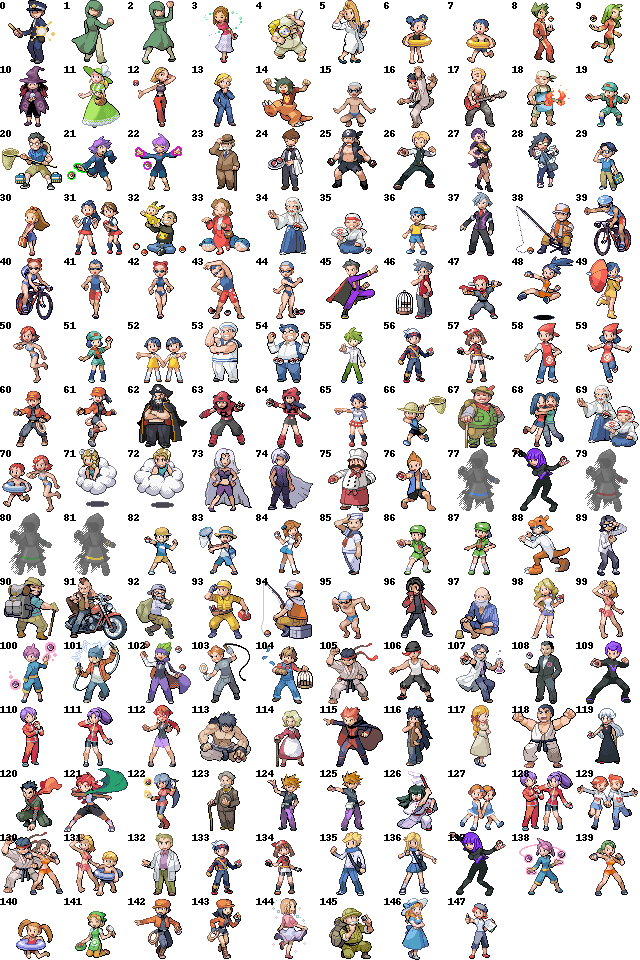

In [18]:
for idx in range(148):
    x = idx % 10
    y = idx // 10
    img.paste(trainer_image(idx), (64 * x , 64 * y))
    img_draw.text((64 * x, 64 * y), str(idx), fill=(0,0,0))
img

In [9]:
0x114

276

In [4]:
shapes = [
    'animal', 'human', 'tail', 'snake', 'winged_insect', 'winged', 'insect', 'head', 'arms', 'legs', 'tentacles', 'fish', 'ball', 'multi'
]
for i, shape in enumerate(shapes):
    print(f'{154 + i} : \'asset/gfx/overworld/npcs/pokeradar/shape_{i}_{shape}/gfx_ow_shape_{shape}_0.png\',')

154 : 'asset/gfx/overworld/npcs/pokeradar/shape_0_animal/gfx_ow_shape_animal_0.png',
155 : 'asset/gfx/overworld/npcs/pokeradar/shape_1_human/gfx_ow_shape_human_0.png',
156 : 'asset/gfx/overworld/npcs/pokeradar/shape_2_tail/gfx_ow_shape_tail_0.png',
157 : 'asset/gfx/overworld/npcs/pokeradar/shape_3_snake/gfx_ow_shape_snake_0.png',
158 : 'asset/gfx/overworld/npcs/pokeradar/shape_4_winged_insect/gfx_ow_shape_winged_insect_0.png',
159 : 'asset/gfx/overworld/npcs/pokeradar/shape_5_winged/gfx_ow_shape_winged_0.png',
160 : 'asset/gfx/overworld/npcs/pokeradar/shape_6_insect/gfx_ow_shape_insect_0.png',
161 : 'asset/gfx/overworld/npcs/pokeradar/shape_7_head/gfx_ow_shape_head_0.png',
162 : 'asset/gfx/overworld/npcs/pokeradar/shape_8_arms/gfx_ow_shape_arms_0.png',
163 : 'asset/gfx/overworld/npcs/pokeradar/shape_9_legs/gfx_ow_shape_legs_0.png',
164 : 'asset/gfx/overworld/npcs/pokeradar/shape_10_tentacles/gfx_ow_shape_tentacles_0.png',
165 : 'asset/gfx/overworld/npcs/pokeradar/shape_11_fish/gfx_ow_s

In [20]:
idx = 0
while True:
    try: trainer_image(idx)
    except:
        print(idx)
        break
    idx += 1

148


# Overworld Gfx

In [ ]:
# 0x382aec, 0x36d74c
img = agb.image.Image(rom[0x382aec : 0x382aec + 8 * 8 // 2], 8, 8)
pal = agb.palette.from_data(rom[0x36d74c : 0x36d74c + 0x20])
img.save('captain.png', pal.to_pil_palette())

In [8]:
hex(4358)

'0x1106'

# Export gfxs

In [6]:
uncompressed_palette = agb.palette.from_data(agb.lz77.decompress(rom, offset=0xd24734))

In [7]:
gfx_shallow_water_offset = 0x39856C
gfx_grass_pal_new_offset = struct.unpack_from('<I', rom, offset=0x3A520C)[0] - 0x8000000
gfx_grass_pal_new = agb.palette.from_data(rom[gfx_grass_pal_new_offset : gfx_grass_pal_new_offset + 0x20])
gfx_grass_pal_old = agb.palette.from_data(rom[0x398E8C : 0x398E8C + 0x20])
gfx_shallow_water = agb.image.Image(rom[0x39856C : 0x39856C + 6 * 0x80], 16, 6 * 16)
gfx_shallow_water.to_pil_image(gfx_grass_pal_new.to_pil_palette())
#gfx_shallow_water.save('asset/gfx/grass_anim/shallow_water.png', gfx_grass_pal_new.to_pil_palette())

In [13]:
itemfinder_arrow_offset = 0x465594
#player_pal_offset = 0x35B82C
player_pal = agb.palette.from_data(rom[player_pal_offset : player_pal_offset + 0x20])
arrow_img = agb.image.Image(rom[itemfinder_arrow_offset : itemfinder_arrow_offset + 0x280], 16, 80)
arrow_img.to_pil_image(player_pal.to_pil_palette())
arrow_img.save('arrow.png', player_pal.to_pil_palette())


In [19]:

shadow_offset = 0x0397f0c
player_pal_offset = 0x35B82C
player_pal = agb.palette.from_data(rom[player_pal_offset : player_pal_offset + 0x20])
img = agb.image.Image(rom[shadow_offset : shadow_offset + 0x200], 16, 64)
img.to_pil_image(player_pal.to_pil_palette())
#arrow_img.save('arrow.png', player_pal.to_pil_palette())

In [8]:
gfx_shallow_water.save('test.png', uncompressed_palette.to_pil_palette())

In [94]:
ow_pal_4_offset = 0x36D70C
ow_pal_4 = agb.palette.from_data(rom[ow_pal_4_offset : ow_pal_4_offset + 0x20])
gfx_shallow_water.save('test.png', ow_pal_4.to_pil_palette())

In [18]:

gfx_shallow_water.save('asset/gfx/grass_anim/shallow_water_old.png', gfx_grass_pal_old.to_pil_palette())

In [15]:
gfx_healthbar_pal = agb.palette.from_data(rom[0xD11B84 : 0xD11B84 + 0x20])
gfx_healthbar_defeated_pal = agb.palette.from_data(rom[0xD11B84 : 0xD11B84 + 0x20])

In [96]:
0x807

2055

In [36]:
healthbars = {
    'gfx_healthbar_player_single_battle' : agb.image.Image(agb.lz77.decompress(rom, offset=0xD1F340), 64, 128),
    'gfx_healthbar_opponent_single_battle' : agb.image.Image(agb.lz77.decompress(rom, offset=0xD1F5F8), 64, 128),
    'gfx_healthbar_player_double_battle' : agb.image.Image(agb.lz77.decompress(rom, offset=0xD1F788), 64, 64),
    'gfx_healthbar_opponent_double_battle' : agb.image.Image(agb.lz77.decompress(rom, offset=0xD1F91C), 64, 64),
    'gfx_healthbar_safari' : agb.image.Image(agb.lz77.decompress(rom, offset=0xD1FAB0), 64, 128),
}

In [34]:
for symbol, image in healthbars.items():
    path = f'asset/gfx/battle/healthbars/{symbol}.png'
    palette = gfx_healthbar_pal.to_pil_palette()
    if symbol == 'gfx_healthbar_defeated': palette = gfx_healthbar_defeated_pal.to_pil_palette()
    image.save(path, palette)


In [37]:
#gfx_healthbar_safari.to_pil_image(gfx_healthbar_pal.to_pil_palette())
#gfx_healthbar_defeated.to_pil_image(gfx_healthbar_defeated_pal.to_pil_palette())

In [9]:
import re

In [10]:
with open('src/map/banks/0/6/script/person/ow_script_0x8fb91f.asm') as f:
    content = f.read()

In [11]:
list(re.findall('additem (.*) (.*)\n', content, flags=re.M))

[('ITEM_WURZELFOSSIL', '0x1'), ('ITEM_KLAUENFOSSIL', '0x1')]

In [ ]:
agb.

# Search for pointers (and strings)

In [7]:
#082527e0
pattern = bytes([0xe0, 0x27, 0x25, 0x8])
offset = -1
for _ in range(100):
    try: offset = rom.index(pattern, offset + 1)
    except: break
    #print(hex(offset))
    print(f'.org {hex(offset + 0x8000000)[:]}\n\t.word item_effects\n\n')

.org 0x803a1b0
	.word item_effects


.org 0x8041448
	.word item_effects


.org 0x8042424
	.word item_effects


.org 0x8042b30
	.word item_effects


.org 0x8042d3c
	.word item_effects


.org 0x812509c
	.word item_effects


.org 0x812579c
	.word item_effects


.org 0x8126d14
	.word item_effects


.org 0x94ba3b4
	.word item_effects


.org 0x94ba7d0
	.word item_effects




In [9]:
pattern = agbstring.str_to_hex('Bist du damit einverstanden?')
pattern = bytes(pattern)[:-1]
offset = -1
for _ in range(100):
    try: offset = rom.index(pattern, offset + 1)
    except: break
    # Find the beginning of the string
    start = offset
    
    while rom[start] != 255:
        start -= 1
    start += 1
        
    print(f'{hex(offset)}\t{agbstring.hex_to_str(rom, start)[0]}')

0x41676e	Ich gebe dir BSC_COPY_BUFFER2\$.\nBist du damit einverstanden?
0x14e5fd8	Halt!\nBevor du dich der Herausforderung\ldieser Arena stellst, solltest du\lwissen, wie hier gekämpft wird.\pDu kämpfst gegen vier Gegner in\nFolge und schließlich gegen Manus,\lden Arenaleiter.\pZwischen den Kämpfen erlauben wir\ndir BSC_COPY_BUFFER0 Mal eines deiner Pokémon\lzu heilen.\pBist du damit einverstanden?
0x1520c61	Allerdings werden alle\nzeitbasierten Events bei einem\lWechsel der Uhr zurückgesetzt.\pBist du damit einverstanden?


209

In [10]:
print(agbstring.hex_to_str(rom, 0x041675c)[0])

Ich gebe dir BSC_COPY_BUFFER2\$.\nBist du damit einverstanden?


In [54]:
for p in find_pointers(rom, 0x03fcf7c): print(hex(p))

0xd792c
0x3fe3bc


In [17]:
offset = -1
for _ in range(100):
    try: offset = rom.index(pattern, offset + 1)
    except: break
    print(f'{hex(offset)}')
    

0x198e79
0x1bd351
0x3fd3eb
0x3fd3f4
0x3fd3fb
0x3fd404
0x3fd40b
0x3fd414
0x415bf8
0x415bff
0x417f2f
0x6abbc3
0x1032b1f
0x1452781
0x145ec0e
0x1460009
0x146002c
0x146004c
0x146006c
0x1460676
0x1460d28
0x1460ed7
0x1460f27
0x1460f66
0x1460f75
0x1460f84
0x1460f95
0x1460fa6
0x1460fb5
0x1465741
0x146dbe9
0x147caae
0x147d7ea
0x147d7f6
0x147ddc5
0x1486515
0x148bc8a
0x148ec0b
0x14928b8
0x14928d4
0x14947fc
0x1494fb8
0x14a46ad
0x14acbb1
0x14b4df7
0x14b51a8
0x14b51fc
0x14cd364
0x14dac45
0x14dac7b
0x14dacc1
0x14db449
0x14db473
0x14db49f
0x14db4cd
0x14db5a9
0x14db5d1
0x14db601
0x14db62d
0x14db733
0x14db787
0x14db7b7
0x14db7e1
0x14db811
0x14dbaa6
0x14dbad2
0x14dbb7e
0x14dbf1b
0x14dd078
0x14dd0fb
0x14dd5a2
0x14dd651
0x14de04a
0x14de179
0x14dee06
0x14dee5f
0x14deeb7
0x14deee4
0x14defee
0x14df3a0
0x14df3ef
0x14df4b7
0x14e0f98
0x14e1178
0x14e12e1
0x14e1560
0x14e1830
0x14e1b28
0x14e6768
0x14e6775
0x14e67c2
0x14e67cf
0x14e67de
0x14e682a
0x14e685b
0x14e6891
0x14e68df
0x14e68f7
0x14e6923
0x14e6963


# Fix map headers and store the shape idxs

In [45]:
shape_idxs = []
for bank in project.headers:
    for map_idx in project.headers[bank]:
        header, label, namespace = project.load_header(bank, map_idx)
        shape_idxs.append((bank, map_idx, header.pop('field_1A')))
        header['level'] = 0
        project.save_header(header, bank, map_idx)

In [46]:
shape_idxs

[('0', '7', 0),
 ('0', '12', 0),
 ('0', '5', 0),
 ('0', '6', 0),
 ('0', '13', 0),
 ('1', '0', 0),
 ('1', '81', 0),
 ('1', '82', 0),
 ('1', '126', 0),
 ('1', '59', 0),
 ('1', '125', 0),
 ('1', '30', 0),
 ('1', '31', 0),
 ('3', '0', 0),
 ('3', '1', 0),
 ('3', '2', 0),
 ('3', '67', 0),
 ('3', '4', 0),
 ('3', '5', 0),
 ('3', '6', 0),
 ('3', '72', 0),
 ('3', '73', 0),
 ('3', '74', 0),
 ('3', '75', 0),
 ('3', '76', 0),
 ('3', '66', 0),
 ('3', '3', 0),
 ('3', '21', 1),
 ('3', '22', 0),
 ('3', '23', 0),
 ('3', '24', 1),
 ('3', '70', 0),
 ('3', '41', 0),
 ('3', '19', 0),
 ('3', '57', 0),
 ('3', '7', '1'),
 ('3', '8', 0),
 ('3', '9', 0),
 ('3', '10', 0),
 ('4', '0', 0),
 ('4', '1', 0),
 ('4', '2', 0),
 ('4', '4', 0),
 ('4', '3', 0),
 ('5', '0', 0),
 ('5', '2', 0),
 ('5', '4', 0),
 ('5', '11', 0),
 ('5', '12', 0),
 ('5', '13', 0),
 ('6', '0', 0),
 ('6', '1', 0),
 ('6', '2', 0),
 ('6', '3', 0),
 ('6', '5', 0),
 ('6', '9', 0),
 ('6', '13', 0),
 ('6', '14', 0),
 ('6', '15', 0),
 ('6', '4', 0),
 ('7'

In [47]:
for bank, map_idx, shape_idx in shape_idxs:
    if shape_idx != 0:
        print(bank, map_idx, shape_idx)

3 21 1
3 24 1
3 7 1
11 1 2
13 0 1
